# MODFLOW API Paper

## Run the steady-state Sagehen MODFLOW 6 model

This notebook can be used to run the steady-state MODFLOW 6 model prior to running the  "Coupling of MODFLOW to PRMS" example, as reported in the MODFLOW 6 API paper (in progress).

## Supported operating systems
This example can be run on the following operating systems:

* linux
* macOS
* Windows

## Prerequisites
To run the simulation and process the results, the following publicly available software and data are required:

* __mf6.exe__ (Windows) or __mf6__ (linux or MacOS) pre-compiled application and available from https://github.com/MODFLOW-USGS/modflow6-nightly-build. The operating specific pre-compiled application should be installed in the `bin` subdirectory at the same level as the subdirectory containing this Jupyter Notebook (`../bin/`). 
* __flopy__ is a python package that can be used to build, run, and post-process MODFLOW 6 models. The source is available at https://github.com/modflowpy/flopy and the package can be installed from PyPI using `pip install flopy` or conda using `conda install flopy`.
* __geopandas__ which can be installed using PyPI (`pip install geopandas`) or conda (`conda install geopandas`).
* __fiona__ which can be installed using PyPI (`pip install fiona`) or conda (`conda install fiona`).

## Running the simulation

We start by importing the necessary packages:

In [3]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import flopy
import geopandas as gpd
import fiona

#### Load the steady-state model

In [4]:
if sys.platform == "win32":
    exe_name = os.path.abspath('../bin/mf6.exe')
else:
    exe_name = os.path.abspath('../bin/mf6')

In [5]:
ws = "sagehenmodelss"
sim = flopy.mf6.MFSimulation().load(sim_ws=ws, exe_name=exe_name)
gwf = sim.get_model("sagehenmodel")

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package oc...
    loading package chd...
    loading package sfr...
    loading package uzf...
    loading package drn...
    loading package mvr...
  loading solution package sagehenmodel...


#### Run the steady-state MODFLOW 6 model

In [7]:
sim.run_simulation()

FloPy is using the following executable to run the model: ..\..\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.0 12/20/2024

   MODFLOW 6 compiled Dec 31 2024 17:10:16 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall

(True, [])

#### Process the geodatabase

In [8]:
file = "Sagehen.gdb"
hru = gpd.read_file(file, driver="FileGDB", layer="HRU")
river = gpd.read_file(file, driver="FileGDB", layer="stream")

##### Set coordinate information for model grid

In [9]:
gwf.modelgrid.set_coord_info(xoff=214860, yoff=4365620, epsg=26911, angrot=12.013768668935385975)

##### Print model discretization shape

In [10]:
gwf.modelgrid.shape, gwf.modelgrid.nnodes

((2, 73, 81), 11826)

#### Get output times

In [11]:
hobj = flopy.utils.HeadFile("sagehenmodelss/output/gwf_sagehen-gsf.hds")
times = np.array(hobj.get_times())
ndays = len(times)

##### Groundwater head

In [12]:
h = hobj.get_data(totim=times[0])

In [13]:
hplt = np.ma.masked_where(h>1e20, h)

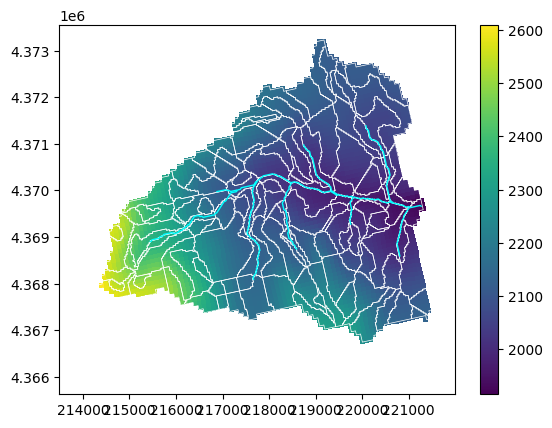

In [14]:
mm = flopy.plot.PlotMapView(model=gwf)
v = mm.plot_array(hplt)
river.plot(ax=mm.ax, color="cyan", lw=1)
hru.plot(ax=mm.ax, edgecolor="white", facecolor="none", lw=0.5)
plt.colorbar(v);

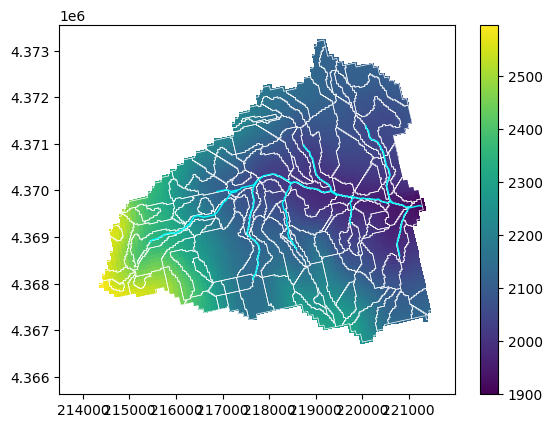

In [15]:
mm = flopy.plot.PlotMapView(model=gwf, layer=1)
v = mm.plot_array(hplt)
river.plot(ax=mm.ax, color="cyan", lw=1)
hru.plot(ax=mm.ax, edgecolor="white", facecolor="none", lw=0.5)
plt.colorbar(v);

##### Depth to water

In [16]:
dtw = gwf.dis.top.array - h[0, :, :]
dtw = np.ma.masked_where(h[0, :, :]>1e20, dtw)

In [17]:
dtw.min(), dtw.max()

(np.float64(-0.6126239096488462), np.float64(64.9634980873875))

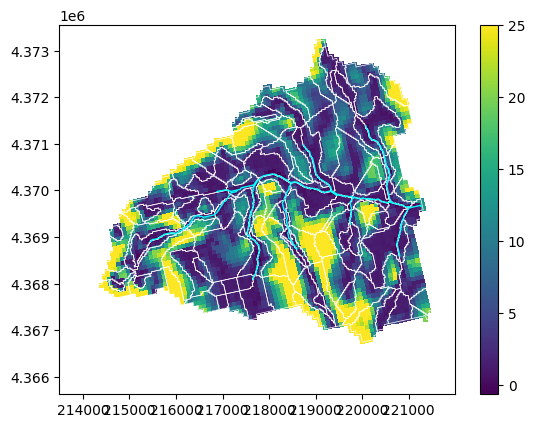

In [18]:
mm = flopy.plot.PlotMapView(model=gwf)
v = mm.plot_array(dtw, vmax=25)
river.plot(ax=mm.ax, color="cyan", lw=1)
hru.plot(ax=mm.ax, edgecolor="white", facecolor="none", lw=0.5)
plt.colorbar(v)

#### Write steady-state heads to a file

In [19]:
for k in range(h.shape[0]):
    fpth = "common/sshead{:02d}.txt".format(k+1)
    np.savetxt(fpth, h[k, :, :], fmt='%15.7g', )